#### **QUESTION**:  
Can we predict which country a first time AirBnB user will book (or no booking) based on their demographic data and marketing acquisition path?

**DATA**: A dataset from AirBnB with the features below:
- 'date_account_created'
- 'timestamp_first_active'
- 'date_first_booking'
- 'gender'
- 'age'
- 'signup_method'
- 'signup_flow'
- 'language'
- 'affiliate_channel'
- 'affiliate_provider'
- 'first_affiliate_tracked'
- 'signup_app'
- 'first_browser'
- 'country_destination'


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

In [2]:
url = '/Users/jennawhite/documents/wild_west/abnb_project/data/train_users_2.csv'

bnb = pd.read_csv(url, index_col='id')


  
### Pre-processing###  

*When looking through the data, I found that there were three features that contained null values. After digging into the recorded values in each feature, I made the following decisions on how to handle the NaN values:*

**date_first_booking**:  
This feature contains timestamps (year-month-day) of when the account holder had their first booking. It also had a NaN value for those who had not booked. I replaced the NaNs with '0', allowing me to also build a dummy variable called 'booked' after.

 

**first_affiliate_tracked**:  
The most populous value in this feature was 'untracked'. There were also 6000+ NaN values (roughly 3% of the observations). Since the % of total observations were low and I felt that NaN was analogous to untracked (in that there was no data on first affiliates for either value), I replaced NaN with 'untracked'.

In [3]:
pd.Series(bnb.first_affiliate_tracked).value_counts()

untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

**age**:  
When I created a histogram of the data for 'age' I found a few peculiarities. First, the general histogram looked like this:

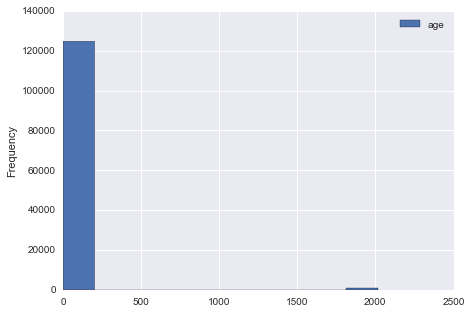

In [4]:
bnb.plot(kind='hist',y='age',figsize=(7,5))

**It was strange that the scale of the x-axis went all the way out to 2500, so I dug in on the outlier:**

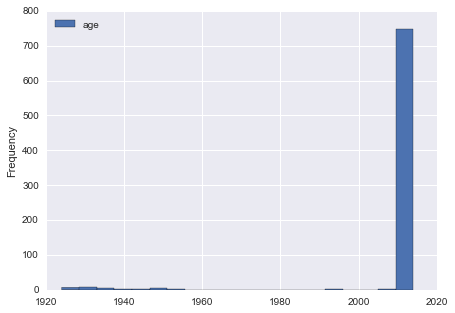

In [5]:
bnb[bnb['age']>1000].plot(kind='hist', y='age', bins=20, figsize=(7,5))

**Specifically, it came out that the large pop was due to people inputting 2014 or 2013 -- most likey the year of signup...not of birth. When looking closer at the beginning of the x-axis I noticed that there were also a significant number of people selecting an age over 80:**


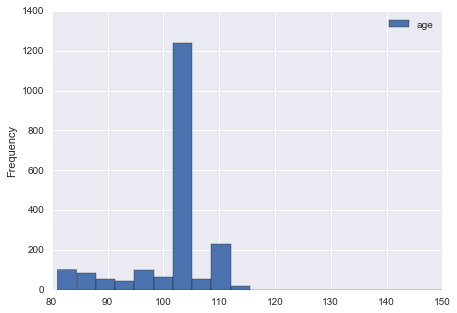

In [6]:
bnb2 = bnb[bnb['age']<1000]
bnb2[bnb2['age']>80].plot(kind='hist', y='age', bins=20, figsize=(7,5))


In [7]:
a = bnb2[bnb2['age']>80]
a['age'].value_counts().head(3)
#you can see that the value counts drop quickly -- 105 must have been a default
# of some sort at some time.

105.0    1131
110.0     196
95.0       49
Name: age, dtype: int64

**Since Ages>80 only accounted for 1.3% of the total observations (or 2771), I decided to drop rows from the dataset where that condition was true.  
  
**But an additional factor in this feature is that there were 89K+ rows that had NaN values. I felt that was too many (~40%) values to drop the rows.

**DATA CLEANING**


In [8]:
#only look at people in these age ranges
bnbA= bnb[(bnb['age']<80) & (bnb['age']>=18)]

In [9]:
#only predict off people who have made a booking
pd.Series(bnbA.date_first_booking).fillna(0, inplace=True)
bnbAx = bnbA[(bnbA['date_first_booking']!=0)]


In [10]:
pd.Series(bnbAx.first_affiliate_tracked).fillna('untracked', inplace=True)

In [11]:
#check to make sure they were pulled out
bnbAx.isnull().any()

date_account_created       False
timestamp_first_active     False
date_first_booking         False
gender                     False
age                        False
signup_method              False
signup_flow                False
language                   False
affiliate_channel          False
affiliate_provider         False
first_affiliate_tracked    False
signup_app                 False
first_device_type          False
first_browser              False
country_destination        False
dtype: bool

In [12]:
#since there is such a long tail of languages and it didn't seem to make a big difference when having them all split out,
#I cut it to english or not

bnbAx['language_english'] = np.where(bnbAx['language']=='en', 1, 0)

/Users/jennawhite/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
bnbAx = pd.concat([bnbAx,pd.get_dummies(bnbAx['first_affiliate_tracked'],prefix='channel')],axis=1)

In [18]:
bnbAx['gender_female'] = np.where(bnbAx['gender']=='FEMALE', 1, 0)

In [17]:
bnbAx['gender_male'] = np.where(bnbAx['gender']=='MALE', 1, 0)

In [14]:
bnbAx['target'] = np.where(bnbAx['country_destination']=='US', 0, 1)

In [21]:
bnbAx = pd.concat([bnbAx,pd.get_dummies(bnbAx['first_device_type'],prefix='device')],axis=1)

In [22]:
#new shape
bnbAx.shape

(67041, 35)

In [23]:
print bnbAx.columns

Index([u'date_account_created', u'timestamp_first_active',
       u'date_first_booking', u'gender', u'age', u'signup_method',
       u'signup_flow', u'language', u'affiliate_channel',
       u'affiliate_provider', u'first_affiliate_tracked', u'signup_app',
       u'first_device_type', u'first_browser', u'country_destination',
       u'language_english', u'channel_linked', u'channel_local ops',
       u'channel_marketing', u'channel_omg', u'channel_product',
       u'channel_tracked-other', u'channel_untracked', u'target',
       u'gender_male', u'gender_female', u'device_Android Phone',
       u'device_Android Tablet', u'device_Desktop (Other)',
       u'device_Mac Desktop', u'device_Other/Unknown',
       u'device_SmartPhone (Other)', u'device_Windows Desktop', u'device_iPad',
       u'device_iPhone'],
      dtype='object')


In [ ]:
bnbAx.head()

### FEATURE SELECTION

#### AGE:  
After cleaning the data, you can see that the  distribution of ages in the data is heavily weighted to those between 25-45 (boxplot below shows the density of those responses)

In [ ]:
bnbAx.age.plot.hist(title='Age Distribution of Bookers', bins=15, figsize = (7,5))

In [ ]:
bnbAx.age.plot.box(figsize=(7,5))

In [ ]:
bnbAx.first_affiliate_tracked.value_counts().plot.bar()

#### Gender

In [ ]:
bnbAx.gender.value_counts().plot.pie()

In [ ]:
bnbAx.gender.value_counts()/len(bnbAx)

In [ ]:
bnbAx.language.value_counts().plot.bar()

In [ ]:
lang_detail = bnbAx.language.value_counts()/len(bnbAx)
print lang_detail.head(5).sum()
print lang_detail.head(5)

In [ ]:
bnbAx.country_destination.value_counts().plot.bar()

In [ ]:
bnbAx.language.value_counts().plot.bar()

### Building the Model

In [ ]:
feature_cols = ['timestamp_first_active','signup_flow']

In [ ]:
X = bnbAx[feature_cols]
X.shape


In [ ]:
X.head()

In [ ]:
y = bnbAx.country_code

In [ ]:
y.shape

In [ ]:
y.head()

**---

### IMPORT MODEL LIBRARIES

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics

In [ ]:
print 'Null Accuracy:'
null = bnbAx.country_code.value_counts()/len(bnbAx)
print null.head(1)

**---

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=123)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=30)

knn.fit(X_train, y_train)

In [ ]:
y_pred_class2 = knn.predict(X_test)

In [ ]:
print 'Accuracy Score:', int(100* metrics.accuracy_score(y_test, y_pred_class2))